In [1]:
### Import packages
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt

### feature engineering
import country_converter as coco
import scipy.stats as ss
from scipy.stats import chi2_contingency
import missingno as msno
from itertools import product
from sklearn.preprocessing import OrdinalEncoder

In [4]:
kaggle=pd.read_csv("kaggle_survey_2020_responses.csv")
kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20036 entries, 0 to 20035
Columns: 355 entries, Time from Start to Finish (seconds) to Q35_B_OTHER
dtypes: int64(1), object(354)
memory usage: 54.3+ MB


In [ ]:
### DATA WRANGLING

In [5]:
### First step: I am only interested in four job titles for this research. So, here is the subset of the originial data
k_int=kaggle[(kaggle['Q5'] == 'Data Analyst') | (kaggle['Q5'] == 'Data Scientist') | (kaggle['Q5'] == 'Data Engineer') | (kaggle['Q5'] == 'Machine Learning Engineer')]
k_int.shape

(5670, 355)

In [6]:
### Some questions in the survey are irrelevant for this project. For instance, certain questions are asked only for BI analysts. 
## The main focus here is to predict who is a data scientist or a data engineers based on the features. I want to depict the differences betweeen data scientists
### and data engineers based on various factors.
k_int= k_int.iloc[: , 1:]
k_int=k_int.drop(k_int.loc[:, 'Q8':'Q14_OTHER'].columns, axis = 1)
k_int=k_int.drop(k_int.loc[:, 'Q18_Part_1':'Q18_OTHER'].columns, axis = 1)
k_int=k_int.drop(k_int.loc[:, 'Q26_A_Part_1':'Q27_A_OTHER'].columns, axis = 1)
k_int=k_int.drop(k_int.loc[:, 'Q29_A_Part_1':'Q30'].columns, axis = 1)
k_int=k_int.drop(k_int.loc[:, 'Q31_A_Part_1':'Q32'].columns, axis = 1)
### Removing supplementary questions: NaN is btw 85% -95%
k_int=k_int.drop(k_int.loc[:, 'Q26_B_Part_1':'Q35_B_OTHER'].columns, axis = 1)

In [7]:
k_int.sample()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,...,Q39_Part_3,Q39_Part_4,Q39_Part_5,Q39_Part_6,Q39_Part_7,Q39_Part_8,Q39_Part_9,Q39_Part_10,Q39_Part_11,Q39_OTHER
12440,25-29,Man,Indonesia,Bachelor’s degree,Data Analyst,5-10 years,Python,NaN,SQL,NaN,...,NaN,NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN


In [8]:
k_int.dtypes

Q1             object
Q2             object
Q3             object
Q4             object
Q5             object
                ...  
Q39_Part_8     object
Q39_Part_9     object
Q39_Part_10    object
Q39_Part_11    object
Q39_OTHER      object
Length: 144, dtype: object

In [ ]:
#### MISSING VALUES - just checking it overall and make a general change

In [9]:
## Second step: deleting the features with more than 70% missing values, naming the columns, and dealing with the missing values in the remaining features
### Higher than 50% missing values = True value - applying a missing value threshold
mask=k_int.isna().sum()/len(k_int) < 0.3
print(mask)
reduced_kint=k_int.loc[:, mask]
reduced_kint.shape
reduced_kint.info()

Q1              True
Q2              True
Q3              True
Q4              True
Q5              True
               ...  
Q39_Part_8     False
Q39_Part_9     False
Q39_Part_10    False
Q39_Part_11    False
Q39_OTHER      False
Length: 144, dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5670 entries, 1 to 20035
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Q1         5670 non-null   object
 1   Q2         5670 non-null   object
 2   Q3         5670 non-null   object
 3   Q4         5670 non-null   object
 4   Q5         5670 non-null   object
 5   Q6         5618 non-null   object
 6   Q7_Part_1  4964 non-null   object
 7   Q15        5167 non-null   object
 8   Q20        5226 non-null   object
 9   Q21        5177 non-null   object
 10  Q22        5108 non-null   object
 11  Q24        4945 non-null   object
 12  Q25        4876 non-null   object
 13  Q38        4443 non-null   object
dtypes: obje

In [10]:
reduced_kint.rename(columns={'Q1':'age','Q2':'gender','Q3':'country','Q4':'educ','Q5':'title','Q6':'experience','Q7_Part_1':'Python_or','Q15':'ML_exp', 'Q20':'comp_size','Q21':'team', 'Q22':'ML_buss','Q24':'salary','Q25':'ML_spent','Q38':'data_tool'}, inplace=True)
reduced_kint.columns

C:\Users\berna\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Index(['age', 'gender', 'country', 'educ', 'title', 'experience', 'Python_or',
       'ML_exp', 'comp_size', 'team', 'ML_buss', 'salary', 'ML_spent',
       'data_tool'],
      dtype='object')

In [11]:
reduced_kint.isna().sum()/len(reduced_kint)

age           0.000000
gender        0.000000
country       0.000000
educ          0.000000
title         0.000000
experience    0.009171
Python_or     0.124515
ML_exp        0.088713
comp_size     0.078307
team          0.086949
ML_buss       0.099118
salary        0.127866
ML_spent      0.140035
data_tool     0.216402
dtype: float64

In [ ]:
### Rearrange the features: Python_or, ML_tool, and ML_algorithm, because NaN's means 0(no), the strings is equivalent to 1(yes).
reduced_kint['Python_or'] = reduced_kint['Python_or'].replace(np.nan,0)
reduced_kint['Python_or'] = reduced_kint['Python_or'].replace(['Python'],1)
reduced_kint['Python_or'].value_counts()

In [ ]:
df = reduced_kint.copy()
df.isna().sum()/len(df)

In [ ]:
df.info()

### FEATURE ENGINEERING

### All features are categorical in the dataset: This step includes transforming the features by creating new features, recategorizing the existing categories, and get the dummies for the analysis

In [ ]:
### FEATURE ENGINEERING: COUNTRY
### SURVEY QUESTION: "In which country do you currently reside?"

# The feature 'Country' contains too many categories. The better approach is to convert countries to continents by creating a new feature.
df.country.unique()

In [ ]:
converter = coco.CountryConverter()
df['region']=converter.convert(names = df['country'], to = 'continent')

In [ ]:
df['region'].value_counts()

In [ ]:
### Due to the inbalanced groups in this feature, I regroup the small groups and merge them under the sub-category 'Other'.
df['region'] = df['region'].replace(['Oceania'],'not found')
df['region'] = df['region'].replace(['Africa'],'not found')
df['region'] = df['region'].replace(['not found'],'Other')
df= df.drop('country', axis=1)

In [ ]:
df['region'] = df['region'].replace(['America'],'1')
df['region'] = df['region'].replace(['Europe'],'2')
df['region'] = df['region'].replace(['Asia'],'3')
df['region'] = df['region'].replace(['Other'],'0')
df['region'].value_counts()

In [ ]:
### At this point, before moving on with feature engineering, let's check the relationship among categories with Chi Square.
#### CHI SQUARE - CORRELATIONS
cat=('age','gender','educ','title','experience','ML_exp','comp_size','team','ML_buss','salary','ML_spent','data_tool','region')
## Let us jump to Chi-Square test
## Creating all possible combinations between the above two variables list
cat_var_prod = list(product(cat,cat, repeat = 1))
print(cat_var_prod)

In [ ]:
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
                            df[i[0]], df[i[1]])))[1]))
print(result)

In [ ]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
# Using pivot function to convert the above DataFrame into a crosstab
x= chi_test_output.pivot(index='var1',columns='var2', values='coeff')
x.round(decimals=2)

In [ ]:
### Almost all features are correlated.

In [ ]:
### FEATURE ENGINEERING_ TARGET FEATURE: SALARY
### SURVEY QUESTION: "What is your current yearly compensation (approximate $USD)?"
df['salary'].value_counts(ascending=False)

In [ ]:
### Regrouping salary based on the number of individuals in each group (group size is considered)
### salary group 1: 0-999
### salary group 2: 1,000-9,999
### salary group 3: 10,000-39,999
### salary group 4: 40,000-99,999
### salary group 5: above 100,000

df["salary"] = df["salary"].map({"$0-999": "1", "1,000-1,999": "2", "2,000-2,999":"2", "3,000-3,999":"2","4,000-4,999":"2", "5,000-7,499":"2","7,500-9,999":"2",\
                                "10,000-14,999":"3","15,000-19,999":"3","20,000-24,999":"3","25,000-29,999":"3","30,000-39,999":"3","40,000-49,999":"4","50,000-59,999":"4",\
                                "60,000-69,999":"4","70,000-79,999":"4","80,000-89,999":"4","90,000-99,999":"4","100,000-124,999":"5","125,000-149,999":"5","150,000-199,999":"5",\
                                "200,000-249,999":"5", "250,000-299,999":"5", "300,000-500,000":"5","> $500,000":"5"})
df['salary'].value_counts()

In [ ]:
### FEATURE ENGINEERING: AGE
### SURVEY QUESTION: "What is your age (# years)?"
### recoded as 20s=1, 30s=2, 40s=3, 50s=4, 60s&above=5
df['age'].unique()
###rename categories in age
df["age"] = df["age"].map({"18-21": "1", "22-24": "1", '25-29':"1", "30-34":"2","35-39":"2", "40-44":"3","45-49":"3","50-54":"4","55-59":"4","60-69":"5","70":"5"})
df['age'].value_counts()

In [ ]:
### FEATURE ENGINEERING: GENDER
### SURVEY QUESTION: "What is your gender?"
df.gender.value_counts()
df['gender'] = df['gender'].replace(['Prefer not to say'],'Other')
df['gender'] = df['gender'].replace(['Prefer to self-describe'],'Other')
df['gender'] = df['gender'].replace(['Nonbinary'],'Other')

In [ ]:
df['gender'] = df['gender'].replace(['Other'],'0')
df['gender'] = df['gender'].replace(['Man'],'1')
df['gender'] = df['gender'].replace(['Woman'],'2')
df.gender.value_counts()

In [ ]:
### FEATURE ENGINEERING: EDUCATION
### SURVEY QUESTION: "What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"
df['educ'].value_counts()
df["educ"] = df["educ"].map({"Master’s degree": "MA", "Bachelor’s degree": "BA", 'Doctoral degree':"PhD", "Some college/university study without earning a bachelor’s degree":"somedegree","Professional degree":"prof", "I prefer not to answer":"noansw","No formal education past high school":"high"})
df['educ'].value_counts()

In [ ]:
### There are still too many sub-categories for education. When I get the dummies for this feature, it will be uncontrollable.
### Also, another problem of too many categories is related to the inbalanced sub-category sizes. 
### However, before make a move, I need to understand its relation to the target feature.
sns.histplot(binwidth=1, x="educ", hue="salary", data=df, stat="count", multiple="stack")
plt.xticks(rotation=45)

In [ ]:
### Based on the visualization, it is clear that those who do not prefer to answer the question are in salary group 1. So, we can merge two groups!
### Also, due to the inbalanced category sizes, I decided to collapse all four groups into one: OTHER (educ_somedegree+educ_prof+educ_high+educ_noanswer)
df['educ'] = df['educ'].replace(['somedegree'],'Other')
df['educ'] = df['educ'].replace(['prof'],'Other')
df['educ'] = df['educ'].replace(['noansw'],'Other')
df['educ'] = df['educ'].replace(['high'],'Other')
df.educ.value_counts()

In [ ]:
### recoding Other=0, BA=1, MA=2, PhD=3
df['educ'] = df['educ'].replace(['Other'],'0')
df['educ'] = df['educ'].replace(['BA'],'1')
df['educ'] = df['educ'].replace(['MA'],'2')
df['educ'] = df['educ'].replace(['PhD'],'3')
df.educ.value_counts()

In [ ]:
### FEATURE ENGINEERING: MACHINE LEARNING EXPERIENCE
### SURVEY QUESTION: "For how many years have you used machine learning methods?"
df.ML_exp.value_counts()

In [ ]:
df['ML_exp'] = df['ML_exp'].replace(['Under 1 year'],'newbie')
df['ML_exp'] = df['ML_exp'].replace(['1-2 years'],'junior')
df['ML_exp'] = df['ML_exp'].replace(['2-3 years'],'mid')
df['ML_exp'] = df['ML_exp'].replace(['3-4 years'],'mid')
df['ML_exp'] = df['ML_exp'].replace(['4-5 years'],'senior')
df['ML_exp'] = df['ML_exp'].replace(['5-10 years'],'senior')
df['ML_exp'] = df['ML_exp'].replace(['10-20 years'],'lead')
df['ML_exp'] = df['ML_exp'].replace(['20 or more years'],'lead')
df.ML_exp.value_counts()

In [ ]:
sns.histplot(binwidth=1, x="ML_exp", hue="experience", data=df, stat="count", multiple="stack")
plt.xticks(rotation=45)

In [ ]:
#After checking the experience in coding/programming, I will decide what to do with the group of 'I do not use machine learning methods' under the ML_experience feature
df['ML_exp'] = df['ML_exp'].replace(['I do not use machine learning methods'],'no_MLexp')

In [ ]:
### Recoding
df['ML_exp'] = df['ML_exp'].replace(['no_MLexp'],'0')
df['ML_exp'] = df['ML_exp'].replace(['newbie'],'1')
df['ML_exp'] = df['ML_exp'].replace(['junior'],'2')
df['ML_exp'] = df['ML_exp'].replace(['mid'],'3')
df['ML_exp'] = df['ML_exp'].replace(['senior'],'4')
df['ML_exp'] = df['ML_exp'].replace(['lead'],'5')
df.ML_exp.value_counts()

In [ ]:
## FEATURE ENGINEERING: EXPERIENCE
### SURVEY QUESTION: "For how many years have you been writing code and/or programming?"
df.experience.value_counts()

In [ ]:
df['experience'] = df['experience'].replace(['< 1 years'],'junior_coder')
df['experience'] = df['experience'].replace(['1-2 years'],'junior_coder')
df['experience'] = df['experience'].replace(['3-5 years'],'midlev_coder')
df['experience'] = df['experience'].replace(['5-10 years'],'midlev_coder')
df['experience'] = df['experience'].replace(['10-20 years'],'senior_coder')
df['experience'] = df['experience'].replace(['20+ years'],'senior_coder')
df.experience.value_counts()

In [ ]:
sns.histplot(binwidth=1, x="ML_exp", hue="experience", data=df, stat="count", multiple="stack")
plt.xticks(rotation=45)

In [ ]:
### It seems like only those who are newbies in ML_experience have no experience in writing codes.
df['experience'] = df['experience'].replace(['I have never written code'],'no_coder')

In [ ]:
#Recode: Ordinal
df['experience'] = df['experience'].replace(['no_coder'],'0')
df['experience'] = df['experience'].replace(['junior_coder'],'1')
df['experience'] = df['experience'].replace(['midlev_coder'],'2')
df['experience'] = df['experience'].replace(['senior_coder'],'3')
df.experience.value_counts()

In [ ]:
### FEATURE ENGINEERING: TITLE
### SURVEY QUESTION: "Select the title most similar to your current role (or most recent title if retired):"
df.title.value_counts()

In [ ]:
### Let's get rid of the white space in between the letters
df.title = df.title.str.replace(" ", "", regex=True)
df.title.unique()

In [ ]:
### TITLE is the TARGET FEATURE.
df['title'] = df['title'].replace(['DataEngineer'],'0')
df['title'] = df['title'].replace(['DataAnalyst'],'0')
df['title'] = df['title'].replace(['MachineLearningEngineer'],'0')
df['title'] = df['title'].replace(['DataScientist'],'1')
df.title.value_counts()

In [ ]:
### FEATURE ENGINEERING: COMPANY SIZE
### SURVEY QUESTION: "What is the size of the company where you are employed?"
df.comp_size.value_counts()
df["comp_size"] = df["comp_size"].map({"0-49 employees": "small_comp", "50-249 employees": "small_comp", "250-999 employees":"midsize_comp", "1000-9,999 employees":"midsize_comp","10,000 or more employees":"big_comp"})
df['comp_size'].value_counts()

In [ ]:
## Recode Ordinal
df['comp_size'] = df['comp_size'].replace(['small_comp'],'1')
df['comp_size'] = df['comp_size'].replace(['midsize_comp'],'2')
df['comp_size'] = df['comp_size'].replace(['big_comp'],'3')
df.comp_size.value_counts()

In [ ]:
### FEATURE ENGINEERING: TEAM SIZE
### SURVEY QUESTION: "Approximately how many individuals are responsible for data science workloads at your place of business?"
### Recode solo_or_small(0 and 1-2)=1, small_mid(3-4 and 5-9)=2, mid_big(10-14, 15-19, and 20)=3
df.team.value_counts()
df['team'] = df['team'].replace(['0'],'1')
df['team'] = df['team'].replace(['1-2'],'1')
df['team'] = df['team'].replace(['3-4'],'2')
df['team'] = df['team'].replace(['5-9'],'2')
df['team'] = df['team'].replace(['10-14'],'3')
df['team'] = df['team'].replace(['15-19'],'3')
df['team'] = df['team'].replace(['20'],'3')
df.team.value_counts()

In [ ]:
### FEATURE ENGINEERING: ML's INCORPORATION INTO BUSINESS
### SURVEY QUESTION: "Does your current employer incorporate machine learning methods into their business?"

df.ML_buss.value_counts()

### Just checking the relationship between individuals' ML experience and companies' structure
sns.histplot(binwidth=1, x="ML_exp", hue="ML_buss", data=df, stat="count", multiple="stack")
plt.xticks(rotation=45)

In [ ]:
###It seems like the higher the individuals' experience in ML, the better they are informed about the company's structure wrt ML.
### Recoding: no use & I do not know=0, exploring=1, insights=2, recently_started=3, established = 4
df['ML_buss'] = df['ML_buss'].replace(['We have well established ML methods (i.e., models in production for more than 2 years)'],'4')
df['ML_buss'] = df['ML_buss'].replace(['We recently started using ML methods (i.e., models in production for less than 2 years)'],'3')
df['ML_buss'] = df['ML_buss'].replace(['We are exploring ML methods (and may one day put a model into production)'],'1')
df['ML_buss'] = df['ML_buss'].replace(['We use ML methods for generating insights (but do not put working models into production)'],'2')
df['ML_buss'] = df['ML_buss'].replace(['No (we do not use ML methods)'],'0')
df['ML_buss'] = df['ML_buss'].replace(['I do not know'],'0')
df.ML_buss.value_counts()

In [ ]:
### FEATURE ENGINEERING: ML SPENDING
### SURVEY QUESTION: "Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years ( approximate $USD )?"
df.ML_spent.value_counts()

In [ ]:
# Recode: no spending=0, little ($1-$99 and $100-$999) = 1, spending ($1000-$9,999, $1000-$9,999, and more)=2
df['ML_spent'] = df['ML_spent'].replace(['$0 ($USD)'],'0')
df['ML_spent'] = df['ML_spent'].replace(['$1-$99'],'1')
df['ML_spent'] = df['ML_spent'].replace(['$100-$999'],'1')
df['ML_spent'] = df['ML_spent'].replace(['$1000-$9,999'],'2')
df['ML_spent'] = df['ML_spent'].replace(['$10,000-$99,999'],'2')
df['ML_spent'] = df['ML_spent'].replace(['$100,000 or more ($USD)'],'2')
df.ML_spent.value_counts()

In [ ]:
### FEATURE ENGINEERING: DATA TOOLS USED IN DATA ANALYSIS
### SURVEY QUESTION: "What is the primary tool that you use at work or school to analyze data? (Include text response)"
df.data_tool.value_counts()

In [ ]:
### Since I am more interested in the data science datatools that are in listed in the first group, I will regroup this variable by introducing only two categories.
df['data_tool'] = df['data_tool'].replace(['Local development environments (RStudio, JupyterLab, etc.)'],'1')
df['data_tool'] = df['data_tool'].replace(['Basic statistical software (Microsoft Excel, Google Sheets, etc.)'],'0')
df['data_tool'] = df['data_tool'].replace(['Business intelligence software (Salesforce, Tableau, Spotfire, etc.)'],'0')
df['data_tool'] = df['data_tool'].replace(['Cloud-based data software & APIs (AWS, GCP, Azure, etc.)'],'0')
df['data_tool'] = df['data_tool'].replace(['Advanced statistical software (SPSS, SAS, etc.)'],'0')
df['data_tool'] = df['data_tool'].replace(['Other'],'0')
df.data_tool.value_counts()

In [ ]:
df=df.iloc[:, [0,1,2,4,5,6,7,8,9,10,11,12,13,3]]
df.info()

In [3]:
df = df.astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5670 entries, 1 to 20035
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         5670 non-null   float64
 1   gender      5670 non-null   float64
 2   educ        5670 non-null   float64
 3   experience  5618 non-null   float64
 4   Python_or   5670 non-null   float64
 5   ML_exp      5167 non-null   float64
 6   comp_size   5226 non-null   float64
 7   team        5177 non-null   float64
 8   ML_buss     5108 non-null   float64
 9   salary      4945 non-null   float64
 10  ML_spent    4876 non-null   float64
 11  data_tool   4443 non-null   float64
 12  region      5670 non-null   float64
 13  title       5670 non-null   float64
dtypes: float64(14)
memory usage: 664.5 KB


<AxesSubplot:>

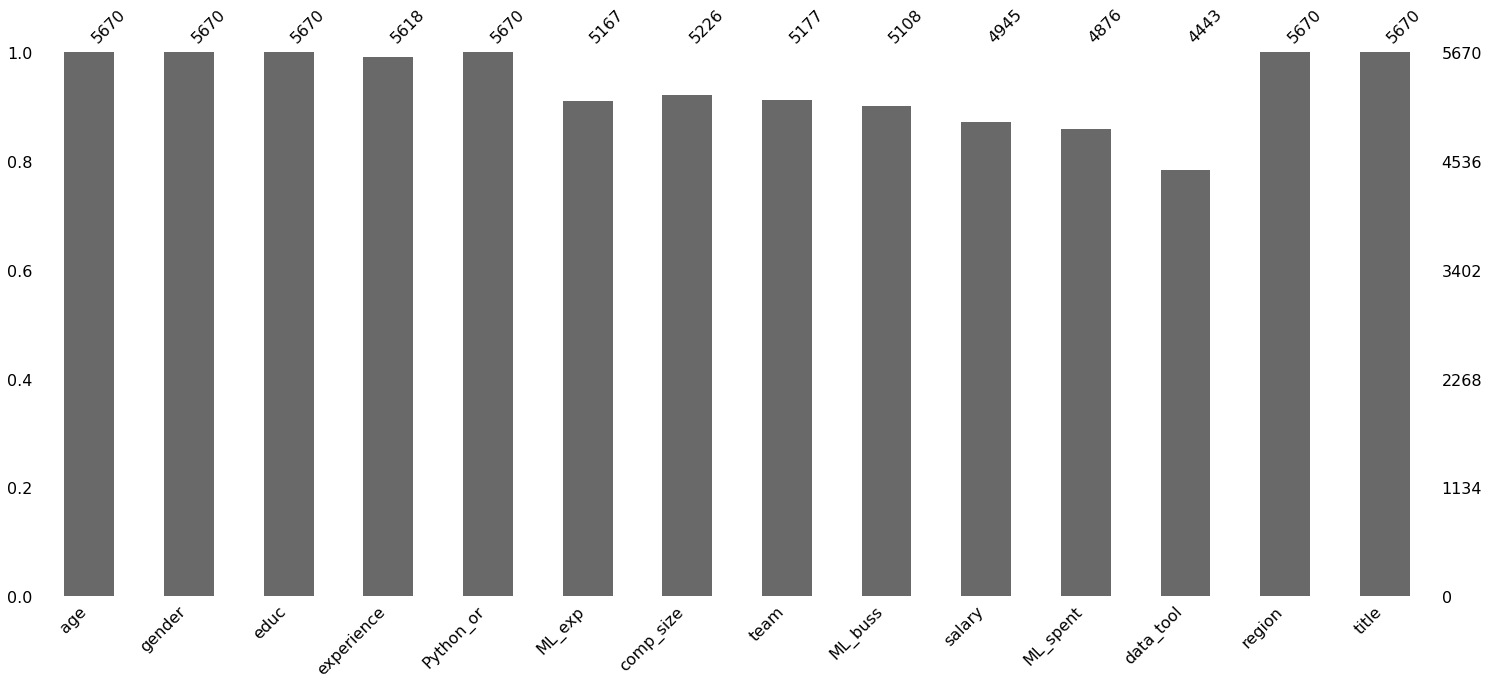

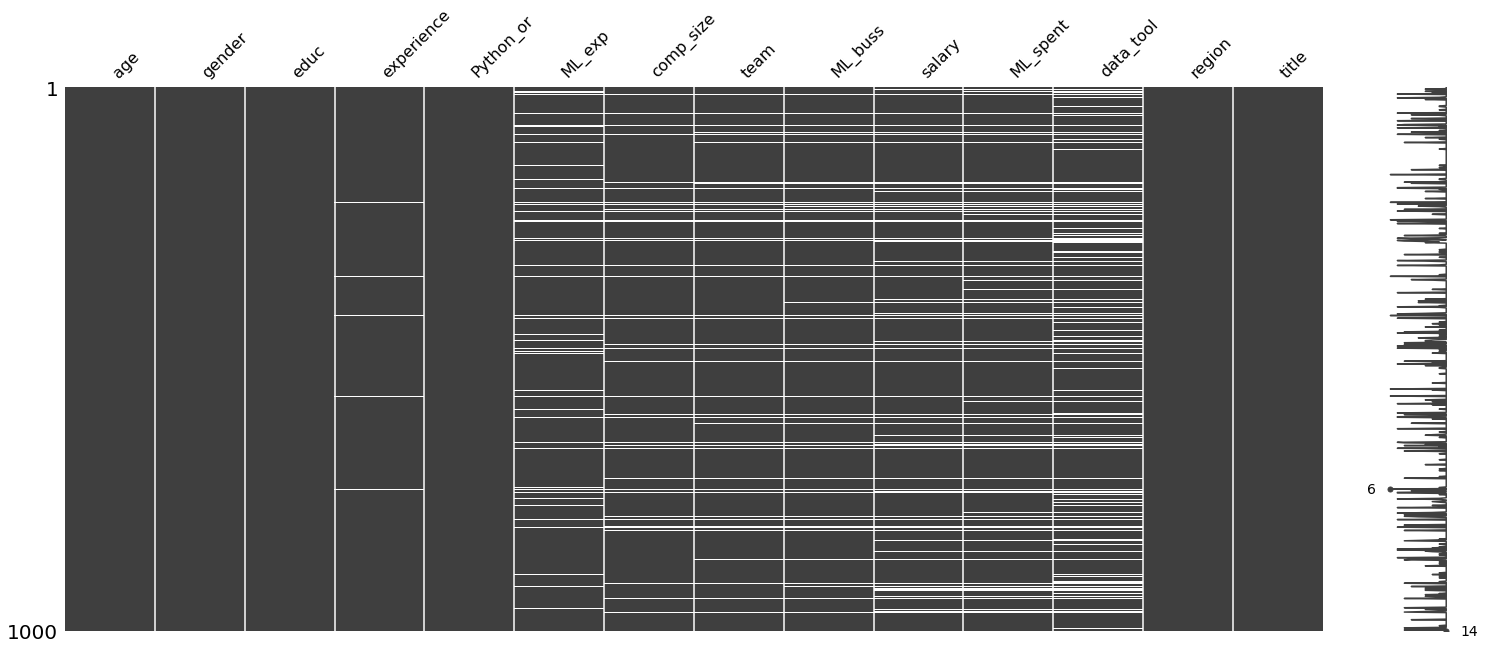

In [4]:
### Examining the missing data
msno.bar(df)
filtered_data = msno.nullity_filter(df, filter='bottom', n=15, p=0.999) # or filter='top'
msno.matrix(df.sample(1000))

<AxesSubplot:>

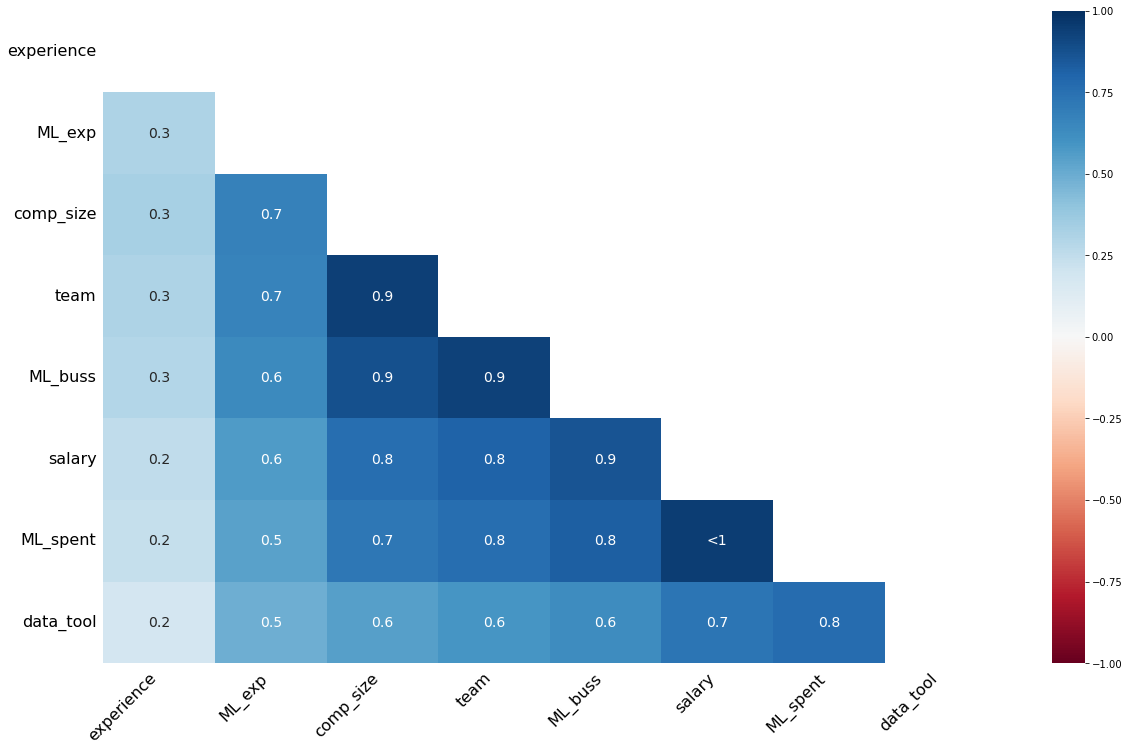

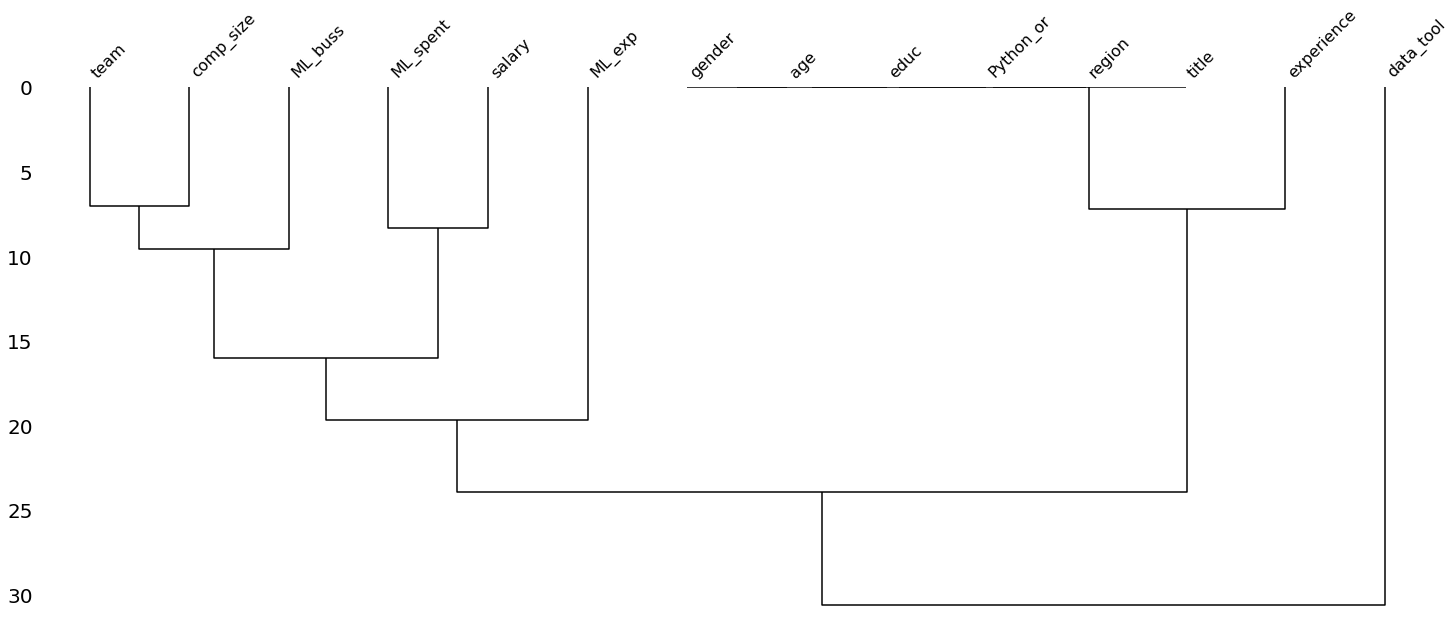

In [5]:
msno.heatmap(df)
### High correlations!
msno.dendrogram(df)

In [6]:
### MISSING VALUES: ORDINAL ENCODING
ordinal_enc_dict = {}
# Loop over columns to encode
for col_name in df:
# Create ordinal encoder for the column
    ordinal_enc_dict[col_name] = OrdinalEncoder()
# Select the non-null values in the column
    col = df[col_name]
    col_not_null = col[col.notnull()]
    reshaped_vals = col_not_null.values.reshape(-1, 1)
# Encode the non-null values of the column
    encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
# Replace the values in the column with ordinal values
    df.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

In [7]:
### IMPUTING WITH KNN
data_KNN_imputed = df.copy(deep=True)
from sklearn.impute import KNNImputer
KNN_imputer=KNNImputer()
data_KNN_imputed.iloc[:, :] = np.round(KNN_imputer.fit_transform(data_KNN_imputed))
for col in data_KNN_imputed:
    reshaped_col = data_KNN_imputed[col].values.reshape(-1, 1)
    data_KNN_imputed[col] = ordinal_enc_dict[col].inverse_transform(reshaped_col)

In [ ]:
### IMPUTING WITH MICE
from fancyimpute import IterativeImputer
mice_imputer = IterativeImputer()
data_mice=df.copy(deep=True)
data_mice.iloc[:,:] = np.round(mice_imputer.fit_transform(data_mice))
for col in data_mice:
    reshaped_col1 = data_mice[col].values.reshape(-1, 1)
    data_mice[col] = ordinal_enc_dict[col].inverse_transform(reshaped_col1)

In [ ]:
### Compare the results
import statsmodels.api as sm
df_cc=df.dropna(how='any')
#df_cc=df_cc.astype('category')
X=sm.add_constant(df_cc.iloc[:, :-1])
y=df_cc['title']

In [10]:
lm=sm.OLS(y, X).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  title   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     49.07
Date:                Tue, 17 May 2022   Prob (F-statistic):          5.22e-119
Time:                        16:14:33   Log-Likelihood:                -2876.0
No. Observations:                4374   AIC:                             5780.
Df Residuals:                    4360   BIC:                             5869.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0909      0.044      2.078      0.0

In [ ]:
### KNN imputation
X1= sm.add_constant(data_KNN_imputed.iloc[:, :-1])
y1=data_KNN_imputed['title']
lm_KNN=sm.OLS(y1,X1).fit()

In [12]:
### MICE imputation
X2= sm.add_constant(data_mice.iloc[:, :-1])
y2=data_mice['title']
lm_mice=sm.OLS(y2,X2).fit()

In [13]:
print(pd.DataFrame({'Complete': lm.rsquared_adj,
'KNN Imp.': lm_KNN.rsquared_adj,
'MICE Imp.': lm_mice.rsquared_adj},
index=['R_squared_adj']))

               Complete  KNN Imp.  MICE Imp.
R_squared_adj  0.125034  0.125996   0.142947


Text(0.5, 0, 'salary')

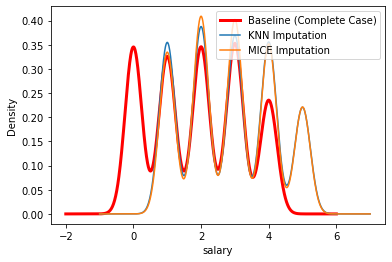

In [14]:
df['salary'].plot(kind='kde', c='red', linewidth=3)
data_KNN_imputed['salary'].plot(kind='kde')
data_mice['salary'].plot(kind='kde')
labels = ['Baseline (Complete Case)', 'KNN Imputation','MICE Imputation']
plt.legend(labels)
plt.xlabel('salary')

In [15]:
### MICE has the best performance in imputation. 
data=data_mice.astype('category')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5670 entries, 1 to 20035
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         5670 non-null   category
 1   gender      5670 non-null   category
 2   educ        5670 non-null   category
 3   experience  5670 non-null   category
 4   Python_or   5670 non-null   category
 5   ML_exp      5670 non-null   category
 6   comp_size   5670 non-null   category
 7   team        5670 non-null   category
 8   ML_buss     5670 non-null   category
 9   salary      5670 non-null   category
 10  ML_spent    5670 non-null   category
 11  data_tool   5670 non-null   category
 12  region      5670 non-null   category
 13  title       5670 non-null   category
dtypes: category(14)
memory usage: 124.1 KB


<AxesSubplot:>

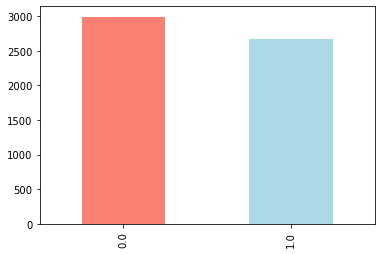

In [76]:
### DATA VISUALIZATION
data.title.value_counts().plot(kind="bar", color=["salmon", "lightblue"])
### We have 2994 non-data scientists and 2676 data scientists, so our problem is balanced.

In [90]:
 data.groupby(['region','title']).size()

region  title
0.0     0.0       494
        1.0       392
1.0     0.0       621
        1.0       663
2.0     0.0       548
        1.0       648
3.0     0.0      1331
        1.0       973
dtype: int64

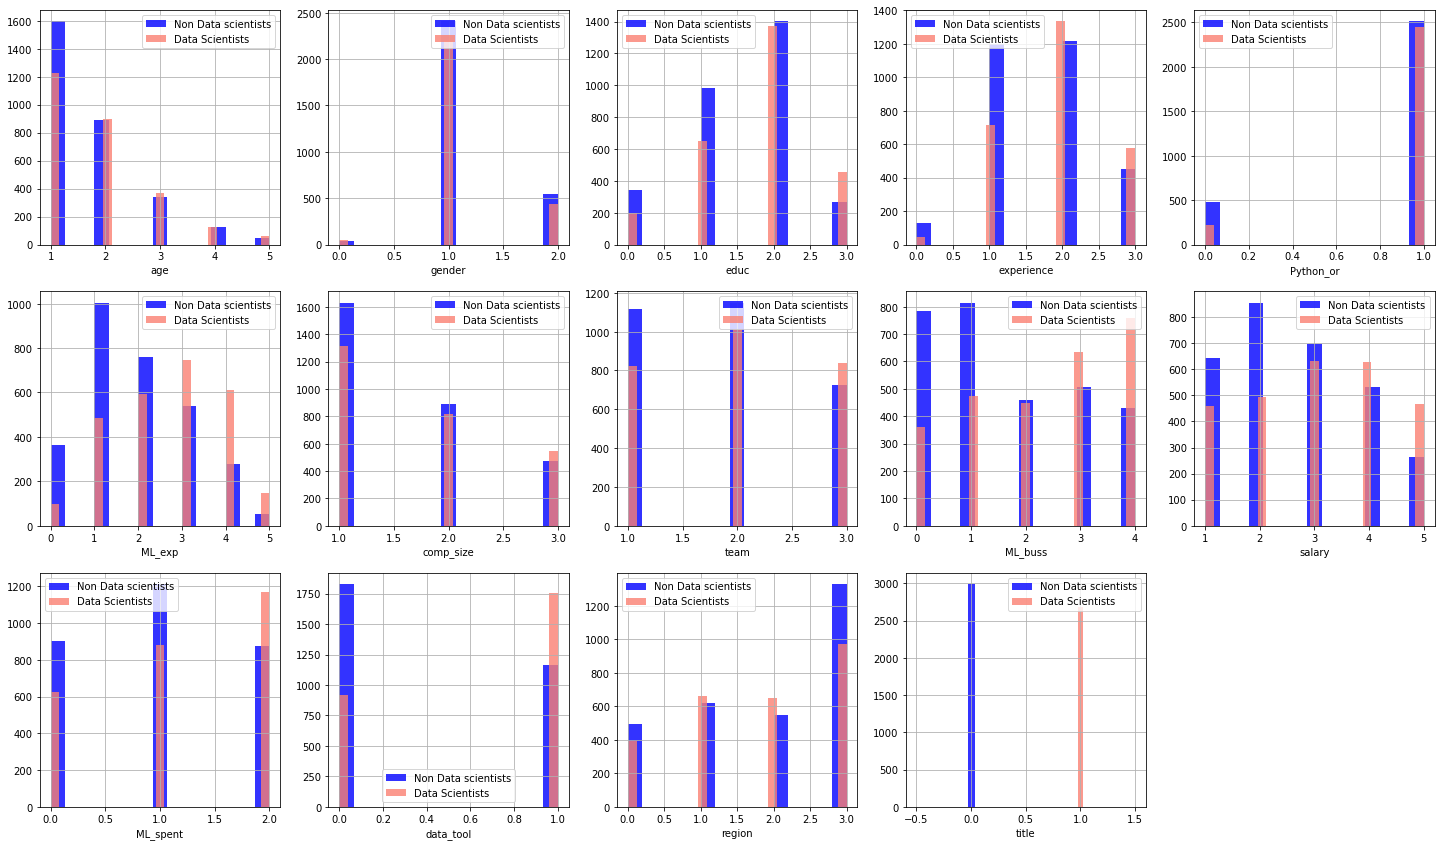

In [75]:
plt.figure(figsize=(25, 25))

for i, column in enumerate(data, 1):
    plt.subplot(5, 5, i)
    data[data["title"] == 0.0][column].hist(bins=15, color='blue', label='Non Data scientists', alpha=0.8)
    data[data["title"] == 1.0][column].hist(bins=25, color='salmon', label='Data Scientists', alpha=0.8)
    plt.legend()
    plt.xlabel(column)

In [ ]:
### Observations from the above plot:20s=1, 30s=2, 40s=3, 50s=4, 60s&above=5
### The size of age groups between data scientists and non-datascientists are almost evenly scattered. However, data scientists are more likely to be in their 30s and 40s.
### The job titles are almost evenly represented by all sexes almost evenly. Though females are more likely to take non-data scientist positions rather than data scientist position.
### 63% of the PhDs in the sample work as data scientists. Non-data scientists are more likely to be dominant in other education categories (other, BA, and MA).
### Data scientists are more likely to be experienced coders(mid-level and senior coders) that non-data scientists.
### Data scientists are slightly more likely to use Python in their daily jobs.
### Data scientists tend to have more experienced in using Machine Learning algorithms (categories - mid, senior, and lead).
### Data scientists are more likely to work in mid-size or big companies as well as mid-size or big teams.
### Data scientists are more likely to work in companies where well-established ML methods are employed.
### Both groups almost equally distributed in various salary categories. However, data scientists are more likely to earn high salaries.
### Data scientists are more likely to work at companies that spend more money to the ML services ($1000-$9,999, $1000-$9,999, and more).
### Data scientists are more likely to use work tools in local development environments (RStudio, JupyterLab).
### Both groups almost equally distributed in various regions of the world; however, data scientists are more likely to be located in America and Europe compared to non-data scientists.

In [91]:
### END OF DATA PREPARATION
data.to_pickle("data_readyforanalysis.pkl")